# Problem statement:
We want to build a surrogate model with a Convolutional Recurrent NN architecture to learn and predict the time-evolution of a bi-dimensional phase-field.
It will be supplied as an image (npy array) with $n \times n$ pixels. The convolutional architecture helps us capturing the local correlations between nearby correlated pixels, while the recurrent architecture helps us better learn the temporal evolution.

## Step 1

We try first simplify the problem by decomposing it into way smaller easier study problems.

The easiest starting point is considering just one single pixel evolving in time following a certain equation of motion.
We choose a time-evolution given by:
$$
x_{t+dt} = x_{t} - \left (cos((x_{t}-1)\pi) \, x_{t} + \frac{1}{10} \right ) \, \alpha \, \text{dt}
$$

We import some useful libraries

In [28]:
import numpy as np
import matplotlib.pyplot as plt

We define some parameters and the function to compute the time-evolution

In [29]:
alpha = 0.05 # scaling factor
dt = 1 # integration time-step
T = 100 # number of time steps
x0 = 1 # initial condition
t = np.arange(T+1) # time
x = np.zeros(T+1) # scalar to evolve

In [30]:
# function defining the time-evolution
def propagate(x, alpha, dt):
    x_i = x*(1 - np.cos((x-1)*np.pi)*alpha*dt) + 0.005*dt
    
    return x_i

In [31]:
# time evolution starting from x_0 = 1
x[0] = x0
for i in range(1, T+1):
    x[i] = propagate(x[i-1], alpha, dt)

Let's check the evolution starting from $x=1$

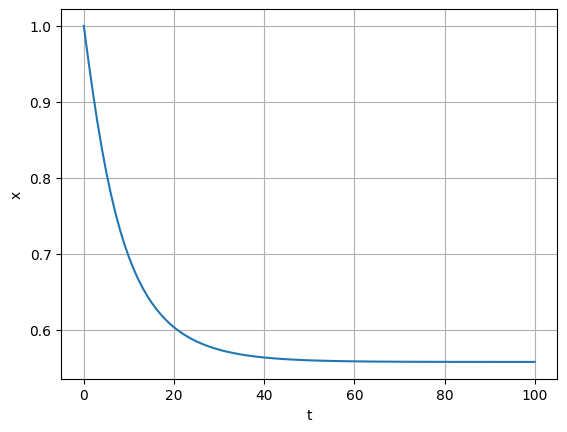

In [32]:
# plotting
plt.plot(t,x)
plt.xlabel('t')
plt.ylabel('x')
plt.grid()

Let's check a bunch of starting conditions

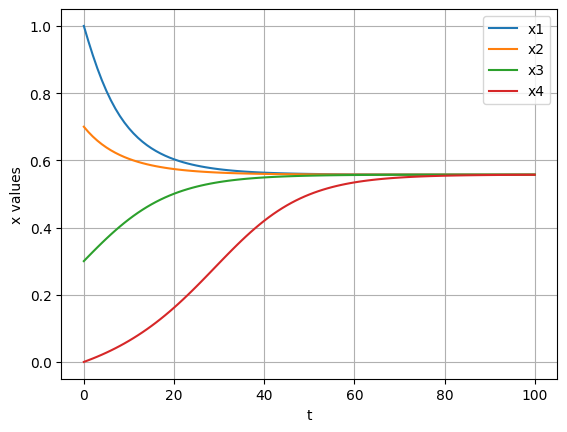

In [33]:
# checking the behaviour formultiple starting conditions
x1 = np.zeros(T+1)
x2 = np.zeros(T+1)
x3 = np.zeros(T+1)
x4 = np.zeros(T+1)
x1[0] = 1.0
x2[0] = 0.7
x3[0] = 0.3
x4[0] = 0.0

for i in range(1, T+1):
    x1[i] = propagate(x1[i-1], alpha, dt)
    x2[i] = propagate(x2[i-1], alpha, dt)
    x3[i] = propagate(x3[i-1], alpha, dt)
    x4[i] = propagate(x4[i-1], alpha, dt)

plt.plot(t, x1, label='x1')
plt.plot(t, x2, label='x2')
plt.plot(t, x3, label='x3')
plt.plot(t, x4, label='x4')
plt.xlabel('t')
plt.ylabel('x values')
plt.legend()
plt.grid()
#plt.yscale('log')

Ok, let's try to learn such dynamics.

First of all we create a dataset of conditions, and we want to predict the next step.

In [34]:
x0s = np.random.rand(300) # starting point
y0s = propagate(x0s, alpha, dt)  # targets

Text(0, 0.5, 'x(t+dt)')

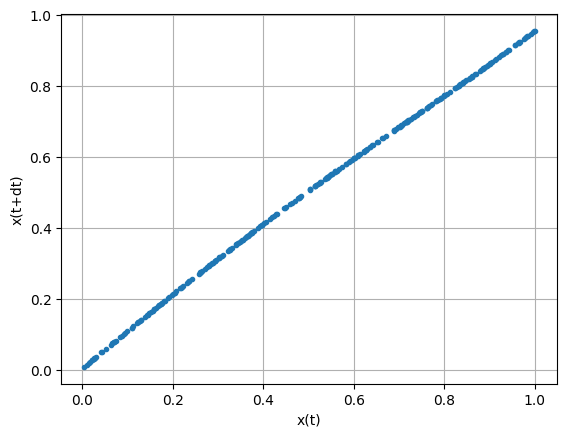

In [35]:
plt.plot(x0s,y0s, '.')
plt.grid()
plt.xlabel('x(t)')
plt.ylabel('x(t+dt)')

A smarter approach is actually to learn the variation rather than the next step directly

Text(0, 0.5, 'dx')

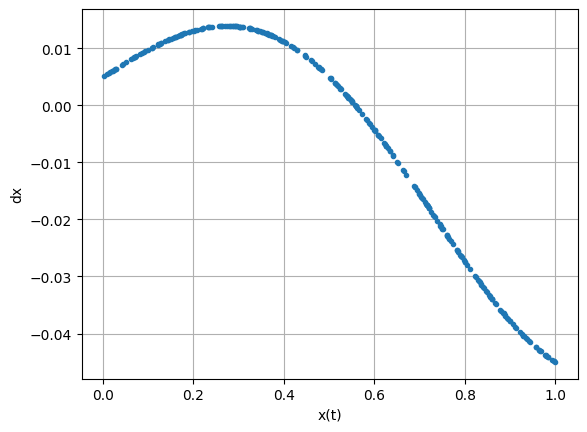

In [36]:
plt.plot(x0s,y0s-x0s, '.')
plt.grid()
plt.xlabel('x(t)')
plt.ylabel('dx')

In [37]:
np.save('inputs.npy', x0s)
np.save('targets.npy', y0s-x0s)

Let's import the libraries to build such NN model

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

Remember, it's good practice to rescale the data

In [39]:
# =========================
# 1. Load dataset
# =========================
X = np.load("inputs.npy")     # shape: (N, d)
y = np.load("targets.npy")    # shape: (N,) or (N, 1)

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)


# Fit scaler on y
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# Wrap into dataset
dataset = TensorDataset(X_tensor, y_tensor)

We also split it into 80% training and 20% validation

In [40]:
# =========================
# 2. Train-validation split
# =========================
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)

For now we define a very simple NN with just one neuron and a ReLU activation function

In [41]:
# =========================
# 3. Define Neural Network
# =========================
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):  # 2 layers, 3 neurons each
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
            nn.ReLU(),
            nn.Linear(2, output_dim)
        )
        
    def forward(self, x):
        return self.layers(x)

# Infer input/output dimensions
input_dim = X.shape[1] if X.ndim > 1 else 1
output_dim = 1 if y.ndim == 1 else y.shape[1]

model = Net(input_dim, output_dim)

In [42]:
# =========================
# 4. Loss and Optimizer
# =========================
criterion = nn.MSELoss()  # regression (use CrossEntropyLoss for classification)
optimizer = optim.Adam(model.parameters(), lr=0.003)

- We train the model for 500 epochs
- Then save the last epoch model
- And also store the loss to check its behaviour during training and validation

In [43]:
# =========================
# 5. Training Loop
# =========================
epochs = 500
loss_tra_saved = np.empty(epochs)
loss_val_saved = np.empty(epochs)
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb.view_as(preds))  # reshape if needed
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb.view_as(preds))
            val_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}")
    
    loss_tra_saved[epoch] = train_loss / 0.8
    loss_val_saved[epoch] = val_loss / 0.2

torch.save(model.state_dict(), "model.pth")

saved_model = Net(1, 1)
saved_model.load_state_dict(torch.load("model.pth"))
saved_model.eval()


Epoch 1/500, Train Loss: 1.0233, Val Loss: 1.0133
Epoch 2/500, Train Loss: 1.0034, Val Loss: 1.0101
Epoch 3/500, Train Loss: 0.9888, Val Loss: 1.0076
Epoch 4/500, Train Loss: 1.0070, Val Loss: 1.0032
Epoch 5/500, Train Loss: 0.9762, Val Loss: 0.9987
Epoch 6/500, Train Loss: 0.9750, Val Loss: 0.9922
Epoch 7/500, Train Loss: 0.9808, Val Loss: 0.9827
Epoch 8/500, Train Loss: 0.9775, Val Loss: 0.9774
Epoch 9/500, Train Loss: 0.9738, Val Loss: 0.9720
Epoch 10/500, Train Loss: 0.9851, Val Loss: 0.9653
Epoch 11/500, Train Loss: 0.9424, Val Loss: 0.9585
Epoch 12/500, Train Loss: 0.9494, Val Loss: 0.9499
Epoch 13/500, Train Loss: 0.9329, Val Loss: 0.9390
Epoch 14/500, Train Loss: 0.9289, Val Loss: 0.9262
Epoch 15/500, Train Loss: 0.9347, Val Loss: 0.9111
Epoch 16/500, Train Loss: 0.8819, Val Loss: 0.8952
Epoch 17/500, Train Loss: 0.8785, Val Loss: 0.8747
Epoch 18/500, Train Loss: 0.8433, Val Loss: 0.8517
Epoch 19/500, Train Loss: 0.8309, Val Loss: 0.8250
Epoch 20/500, Train Loss: 0.8076, Val Lo

Net(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=1, bias=True)
  )
)

We plot the training and validation loss

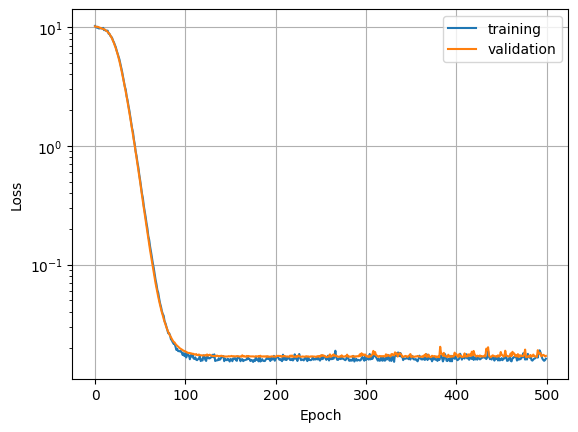

In [44]:
plt.plot(range(epochs), loss_tra_saved, label='training')
plt.plot(range(epochs), loss_val_saved, label='validation')
plt.legend()
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

We initializate an array of test cases to check the prediction power of our saved model

In [45]:
x_test = np.linspace(0, 1, 500) # starting point
y_test = propagate(x_test, alpha, dt)  # targets
X_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Fit scaler on y
y_test_scaled = y_scaler.transform(y)

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

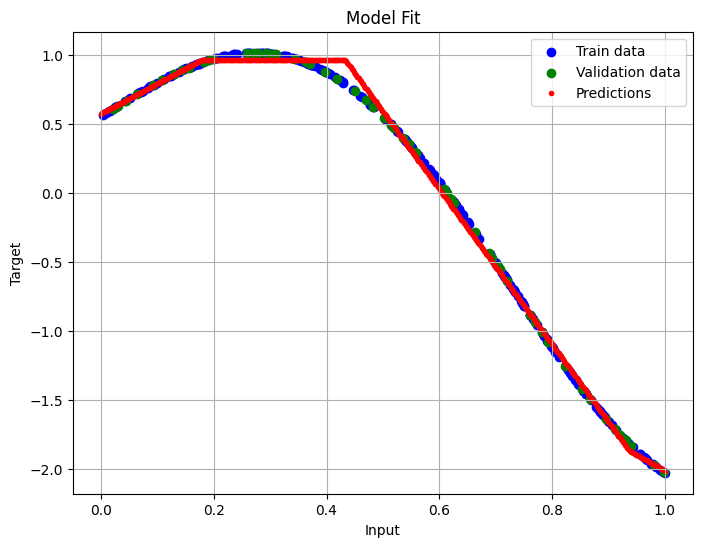

In [46]:
# Training data
X_train = train_dataset[:][0].numpy()
y_train = train_dataset[:][1].numpy()

# Validation data
X_val = val_dataset[:][0].numpy()
y_val = val_dataset[:][1].numpy()

# Predictions on validation data
with torch.no_grad():
    y_pred_test = saved_model(torch.tensor(X_test, dtype=torch.float32)).numpy()

plt.figure(figsize=(8,6))

plt.scatter(X_train, y_train, color="blue", label="Train data")
plt.scatter(X_val, y_val, color="green", label="Validation data")
plt.scatter(X_test, y_pred_test, color="red", marker=".", label="Predictions")

plt.legend()
plt.xlabel("Input")
plt.ylabel("Target")
plt.title("Model Fit")
plt.grid()

And finally we check how it performs in modelling dynamics

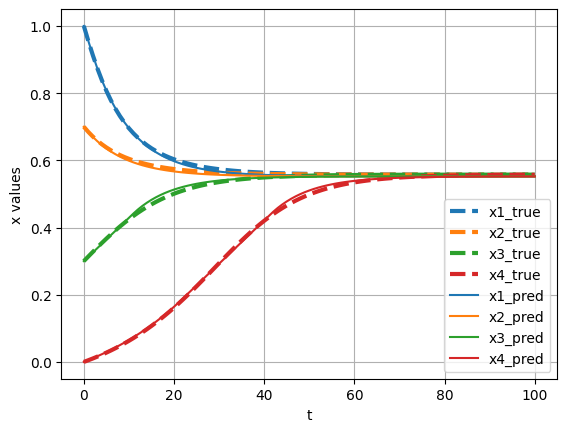

In [47]:
# checking the behaviour for multiple starting conditions
x1_true = np.zeros(T+1)
x2_true = np.zeros(T+1)
x3_true = np.zeros(T+1)
x4_true = np.zeros(T+1)
x1_true[0] = 1.0
x2_true[0] = 0.7
x3_true[0] = 0.3
x4_true[0] = 0.0

x1_pred = np.zeros(T+1)
x2_pred = np.zeros(T+1)
x3_pred = np.zeros(T+1)
x4_pred = np.zeros(T+1)
x1_pred[0] = 1.0
x2_pred[0] = 0.7
x3_pred[0] = 0.3
x4_pred[0] = 0.0


for i in range(1, T+1):
    x1_true[i] = propagate(x1_true[i-1], alpha, dt)
    x2_true[i] = propagate(x2_true[i-1], alpha, dt)
    x3_true[i] = propagate(x3_true[i-1], alpha, dt)
    x4_true[i] = propagate(x4_true[i-1], alpha, dt)

# Predictions on validation data
with torch.no_grad():
    for i in range(1, T+1):
        x1_pred[i] = x1_pred[i-1] + y_scaler.inverse_transform(saved_model(torch.tensor(x1_pred[i-1].reshape(-1,1), dtype=torch.float32)).numpy()).flatten()[0]
        x2_pred[i] = x2_pred[i-1] + y_scaler.inverse_transform(saved_model(torch.tensor(x2_pred[i-1].reshape(-1,1), dtype=torch.float32)).numpy()).flatten()[0]
        x3_pred[i] = x3_pred[i-1] + y_scaler.inverse_transform(saved_model(torch.tensor(x3_pred[i-1].reshape(-1,1), dtype=torch.float32)).numpy()).flatten()[0]
        x4_pred[i] = x4_pred[i-1] + y_scaler.inverse_transform(saved_model(torch.tensor(x4_pred[i-1].reshape(-1,1), dtype=torch.float32)).numpy()).flatten()[0]

plt.plot(t, x1_true,'--', label='x1_true', linewidth=3)
plt.plot(t, x2_true,'--', label='x2_true', linewidth=3)
plt.plot(t, x3_true,'--', label='x3_true', linewidth=3)
plt.plot(t, x4_true,'--', label='x4_true', linewidth=3)
first_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
plt.plot(t, x1_pred, '-', label="x1_pred", color=first_color)
first_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
plt.plot(t, x2_pred, '-', label="x2_pred", color=first_color)
first_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
plt.plot(t, x3_pred, '-', label="x3_pred", color=first_color)
first_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
plt.plot(t, x4_pred, '-', label="x4_pred", color=first_color)

plt.xlabel('t')
plt.ylabel('x values')
plt.legend()
plt.grid()
#plt.yscale('log')

We can do better!

As we are going to make many attempts, it's useful for us to define some functions to proceed in a clear way.

- N: size of the dataset

In [48]:
def generate_dataset(N, alpha=alpha, dt=dt):
    x0s = np.random.rand(N) # starting point
    y0s = propagate(x0s, alpha, dt)  # targets

    np.save('inputs.npy', x0s)
    np.save('targets.npy', y0s-x0s)

    # =========================
    # 1. Load dataset
    # =========================
    X = np.load("inputs.npy")     # shape: (N, d)
    y = np.load("targets.npy")    # shape: (N,) or (N, 1)

    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Fit scaler on y
    y_scaler = StandardScaler()
    y_scaled = y_scaler.fit_transform(y)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

    # Wrap into dataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # =========================
    # 2. Train-validation split
    # =========================
    val_ratio = 0.2
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=32)

    return train_dataset, val_dataset, train_loader, val_loader, y_scaler

    

In [ ]:
def new_model(in_dim, out_dim, act_fun, my_nn, lr, epochs, train_loader, val_loader):
    class Net(nn.Module):
        def __init__(self, in_dim, out_dim):  
            super(Net, self).__init__()
            if len(my_nn) == 1:
                if act_fun == 'ReLU':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.ReLU(),
                        nn.Linear(my_nn[0], out_dim),
                    )
            
                if act_fun == 'ELU':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.ELU(),
                        nn.Linear(my_nn[0], out_dim),
                    )

                if act_fun == 'Tanh':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.Tanh(),
                        nn.Linear(my_nn[0], out_dim),
                    )

            if len(my_nn) == 2:
                if act_fun == 'ReLU':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.ReLU(),
                        nn.Linear(my_nn[0], my_nn[-1]),
                        nn.ReLU(),
                        nn.Linear(my_nn[-1], out_dim),
                    )
            
                if act_fun == 'ELU':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.ELU(),
                        nn.Linear(my_nn[0], my_nn[-1]),
                        nn.ELU(),
                        nn.Linear(my_nn[-1], out_dim),
                    )

                if act_fun == 'Tanh':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.Tanh(),
                        nn.Linear(my_nn[0], my_nn[-1]),
                        nn.Tanh(),
                        nn.Linear(my_nn[-1], out_dim),
                    )
        
        def forward(self, x):
            return self.layers(x)

    # Infer input/output dimensions
    #input_dim = X.shape[1] if X.ndim > 1 else 1
    #output_dim = 1 if y.ndim == 1 else y.shape[1]

    model = Net(in_dim, out_dim)

    criterion = nn.MSELoss()  
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_tra_saved = np.empty(epochs)
    loss_val_saved = np.empty(epochs)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.view_as(preds))  # reshape if needed
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = criterion(preds, yb.view_as(preds))
                val_loss += loss.item()
    
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}")
    
        loss_tra_saved[epoch] = train_loss / 0.8
        loss_val_saved[epoch] = val_loss / 0.2

    torch.save(model.state_dict(), "model.pth")

    saved_model = Net(1, 1)
    saved_model.load_state_dict(torch.load("model.pth"))
    saved_model.eval()

    return loss_tra_saved, loss_val_saved, saved_model

In [50]:
def plot_loss(epochs, loss_tra_saved, loss_val_saved):
    plt.plot(range(epochs), loss_tra_saved, label='training')
    plt.plot(range(epochs), loss_val_saved, label='validation')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()

In [51]:
def next_step_pred(train_dataset, val_dataset, saved_model, X_test):
    X_train = train_dataset[:][0].numpy()
    y_train = train_dataset[:][1].numpy()

    X_val = val_dataset[:][0].numpy()
    y_val = val_dataset[:][1].numpy()

    with torch.no_grad():
        y_pred_test = saved_model(torch.tensor(X_test, dtype=torch.float32)).numpy()

    plt.figure(figsize=(8,6))

    plt.scatter(X_train, y_train, color="blue", label="Train data")
    plt.scatter(X_val, y_val, color="green", label="Validation data")
    plt.scatter(X_test, y_pred_test, color="red", marker=".", label="Predictions")

    plt.legend()
    plt.xlabel("Input")
    plt.ylabel("Target")
    plt.title("Model Fit on Training and Validation Data")
    plt.grid()

In [52]:
def predict_dynamics(alpha, dt, y_scaler, saved_model):
    t = np.arange(T+1)
    x1_true = np.zeros(T+1)
    x2_true = np.zeros(T+1)
    x3_true = np.zeros(T+1)
    x4_true = np.zeros(T+1)
    x1_true[0] = 1.0
    x2_true[0] = 0.7
    x3_true[0] = 0.3
    x4_true[0] = 0.0

    x1_pred = np.zeros(T+1)
    x2_pred = np.zeros(T+1)
    x3_pred = np.zeros(T+1)
    x4_pred = np.zeros(T+1)
    x1_pred[0] = 1.0
    x2_pred[0] = 0.7
    x3_pred[0] = 0.3
    x4_pred[0] = 0.0


    for i in range(1, T+1):
        x1_true[i] = propagate(x1_true[i-1], alpha, dt)
        x2_true[i] = propagate(x2_true[i-1], alpha, dt)
        x3_true[i] = propagate(x3_true[i-1], alpha, dt)
        x4_true[i] = propagate(x4_true[i-1], alpha, dt)

    with torch.no_grad():
        for i in range(1, T+1):
            x1_pred[i] = x1_pred[i-1] + y_scaler.inverse_transform(saved_model(torch.tensor(x1_pred[i-1].reshape(-1,1), dtype=torch.float32)).numpy()).flatten()[0]
            x2_pred[i] = x2_pred[i-1] + y_scaler.inverse_transform(saved_model(torch.tensor(x2_pred[i-1].reshape(-1,1), dtype=torch.float32)).numpy()).flatten()[0]
            x3_pred[i] = x3_pred[i-1] + y_scaler.inverse_transform(saved_model(torch.tensor(x3_pred[i-1].reshape(-1,1), dtype=torch.float32)).numpy()).flatten()[0]
            x4_pred[i] = x4_pred[i-1] + y_scaler.inverse_transform(saved_model(torch.tensor(x4_pred[i-1].reshape(-1,1), dtype=torch.float32)).numpy()).flatten()[0]

    plt.plot(t, x1_true,'--', label='x1_true', linewidth=3)
    plt.plot(t, x2_true,'--', label='x2_true', linewidth=3)
    plt.plot(t, x3_true,'--', label='x3_true', linewidth=3)
    plt.plot(t, x4_true,'--', label='x4_true', linewidth=3)
    first_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    plt.plot(t, x1_pred, '-', label="x1_pred", color=first_color)
    second_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
    plt.plot(t, x2_pred, '-', label="x2_pred", color=second_color)
    third_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
    plt.plot(t, x3_pred, '-', label="x3_pred", color=third_color)
    fourth_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
    plt.plot(t, x4_pred, '-', label="x4_pred", color=fourth_color)

    plt.xlabel('t')
    plt.ylabel('x values')
    plt.legend()
    plt.grid()

What works:
- dataset size: 500
- train val split: 0.20
- layers/neurons: [3]
- activation functions: Tanh
- learning rate: 0.001
- epochs: 3000

In [58]:
N = 500
in_dim = 1
out_dim = 1
act_fun = 'Tanh'
my_nn = [3]
lr = 0.001
epochs = 3000

In [59]:
train_dataset, val_dataset, train_loader, val_loader, y_scaler = generate_dataset(N=N, alpha=alpha, dt=dt)
loss_tra_saved, loss_val_saved, saved_model = new_model(in_dim=in_dim, out_dim=out_dim, 
                                                        act_fun=act_fun, my_nn=my_nn, lr=lr, epochs=epochs, 
                                                        train_loader=train_loader, val_loader=val_loader)

Epoch 1/3000, Train Loss: 1.4233, Val Loss: 1.0908
Epoch 2/3000, Train Loss: 1.4005, Val Loss: 1.0686
Epoch 3/3000, Train Loss: 1.3704, Val Loss: 1.0495
Epoch 4/3000, Train Loss: 1.2969, Val Loss: 1.0337
Epoch 5/3000, Train Loss: 1.3050, Val Loss: 1.0203
Epoch 6/3000, Train Loss: 1.2678, Val Loss: 1.0087
Epoch 7/3000, Train Loss: 1.2695, Val Loss: 0.9989
Epoch 8/3000, Train Loss: 1.2524, Val Loss: 0.9899
Epoch 9/3000, Train Loss: 1.2517, Val Loss: 0.9816
Epoch 10/3000, Train Loss: 1.2117, Val Loss: 0.9745
Epoch 11/3000, Train Loss: 1.2031, Val Loss: 0.9678
Epoch 12/3000, Train Loss: 1.1959, Val Loss: 0.9614
Epoch 13/3000, Train Loss: 1.1823, Val Loss: 0.9559
Epoch 14/3000, Train Loss: 1.1693, Val Loss: 0.9505
Epoch 15/3000, Train Loss: 1.1862, Val Loss: 0.9455
Epoch 16/3000, Train Loss: 1.1595, Val Loss: 0.9410
Epoch 17/3000, Train Loss: 1.1559, Val Loss: 0.9360
Epoch 18/3000, Train Loss: 1.1176, Val Loss: 0.9317
Epoch 19/3000, Train Loss: 1.1286, Val Loss: 0.9270
Epoch 20/3000, Train 

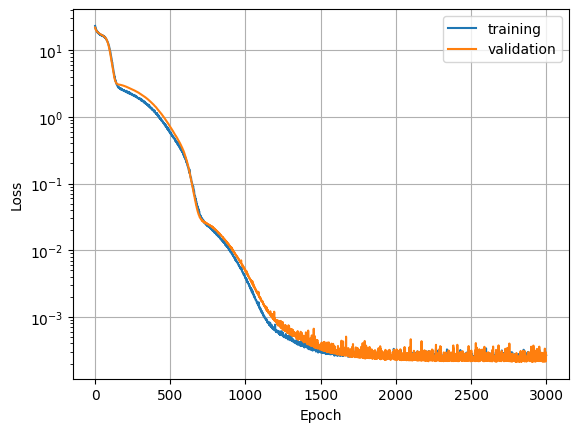

In [60]:
plot_loss(epochs, loss_tra_saved, loss_val_saved)

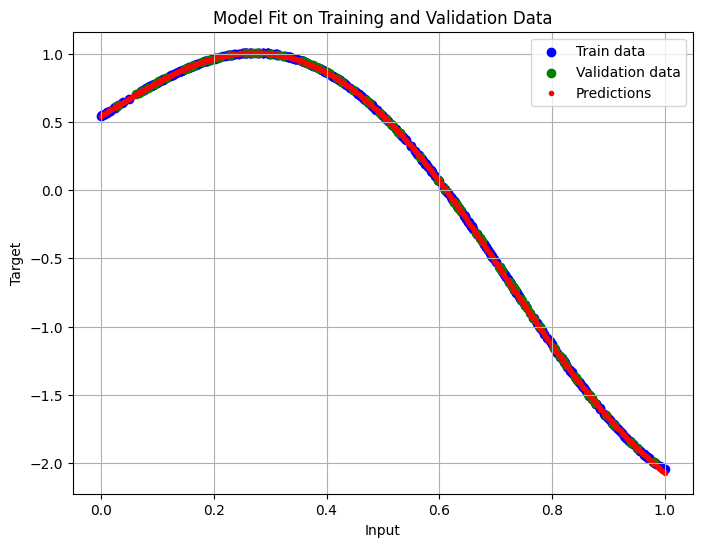

In [61]:
next_step_pred(train_dataset=train_dataset, val_dataset=val_dataset, saved_model=saved_model, X_test=X_test)

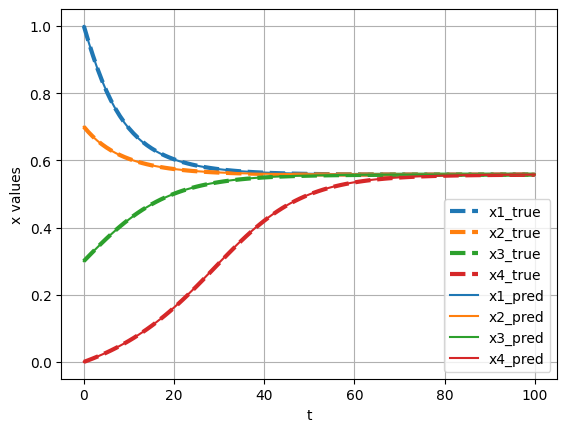

In [62]:
predict_dynamics(alpha=alpha, dt=dt, y_scaler=y_scaler, saved_model=saved_model)